Analyse results computed from process.ipynb.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from genepy3d.io import swc
from genepy3d.obj import surfaces

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits import mplot3d
%matplotlib notebook

# Clean up results

In [2]:
# import brain outline surfaces
brain_surfs = np.load("output/brain_surfaces_step5.npy",allow_pickle=True).item()

# import processed dataframe
df = pd.read_csv("output/features_step5.csv")

# exclude non contact neurons
sdf = df[df["contact_type"]!="None"].copy() 

# take mean values of features (length, tortuosity, etc) by region ID and contact type
sdf_group = sdf.groupby(["region_id","contact_type"]).mean().reset_index(level="contact_type")

# count neurons by brain region ID and contact type
sdf_count = sdf.groupby(["region_id","contact_type"])["neuron_id"].count().reset_index(level="contact_type")

# assign new column of nb. of neurons into sdf_group
sdf_group["count"] = sdf_count["neuron_id"]

# exclude cases whose nb. of neurons smaller than 20th percentile
count_thr = np.percentile(sdf_group["count"].values,20)
print("minimal number of neurons per regions:",count_thr)
sdf_group = sdf_group[sdf_group["count"]>=count_thr].copy()

# loading local 3d scale dataframe
# read our paper for more detail: https://www.biorxiv.org/content/10.1101/2020.06.01.127035v1  
lsdf = pd.read_csv("output/local_3d_scale.csv")
lsdf.set_index("id",inplace=True)

# add new column "local_3d_scale" into sdf_group using data from lsdf
lscol = []
for irow in range(len(sdf_group)):
    regid = sdf_group.index[irow]
    record = lsdf.loc[regid]
    if sdf_group.iloc[irow]["contact_type"]=="Arriving":
        lscol.append(record["lsmean_arr"])
    elif sdf_group.iloc[irow]["contact_type"]=="Originating":
        lscol.append(record["lsmean_star"])
    elif sdf_group.iloc[irow]["contact_type"]=="Passing":
        lscol.append(record["lsmean_pass"])
sdf_group["local_3d_scale"] = lscol

minimal number of neurons per regions: 6.800000000000001


In [3]:
# a quick overview of sdf_group
sdf_group

contact_type  sub_region_id    neuron_id  total_length  \
region_id                                                          
1             Arriving       1.469484   969.507042    107.536703   
1          Originating       1.488189   968.866142     40.452792   
1              Passing       1.515152   899.151515     28.681003   
2             Arriving       1.000000   981.228188    133.774144   
2          Originating       1.000000   904.545082    122.063168   
...                ...            ...          ...           ...   
35         Originating       1.090909  1073.090909     27.761214   
35             Passing       1.333333   995.888889     14.001806   
36            Arriving       1.526316  1075.526316     61.000661   
36         Originating       1.413793  1066.551724     47.770917   
36             Passing       1.571429   878.642857     21.598658   

           nb_branchings  tortuosity  count  local_3d_scale  
region_id                                                    
1               3.234742    1.332187    213       49.849393  
1               0.496063    1.232066    127       51.398763  
1               0.212121    1.230332     33       54.466628  
2               4.100671    1.428279    149       57.360415  
2               0.426230    1.578195    244       50.885749  
...                  ...         ...    ...             ...  
35              1.000000    1.213095     11       45.444226  
35              0.055556    1.176698     18       61.185760  
36              2.947368    1.280680     19       50.109769  
36              1.172414    1.169434     29       52.283966  
36              0.000000    1.095395     14       69.139961  

[84 rows x 8 columns]

# Pairplot

Display correlation between features and their distributions over three groups: arriving to / originating from / passing through neurons.

<IPython.core.display.Javascript object>


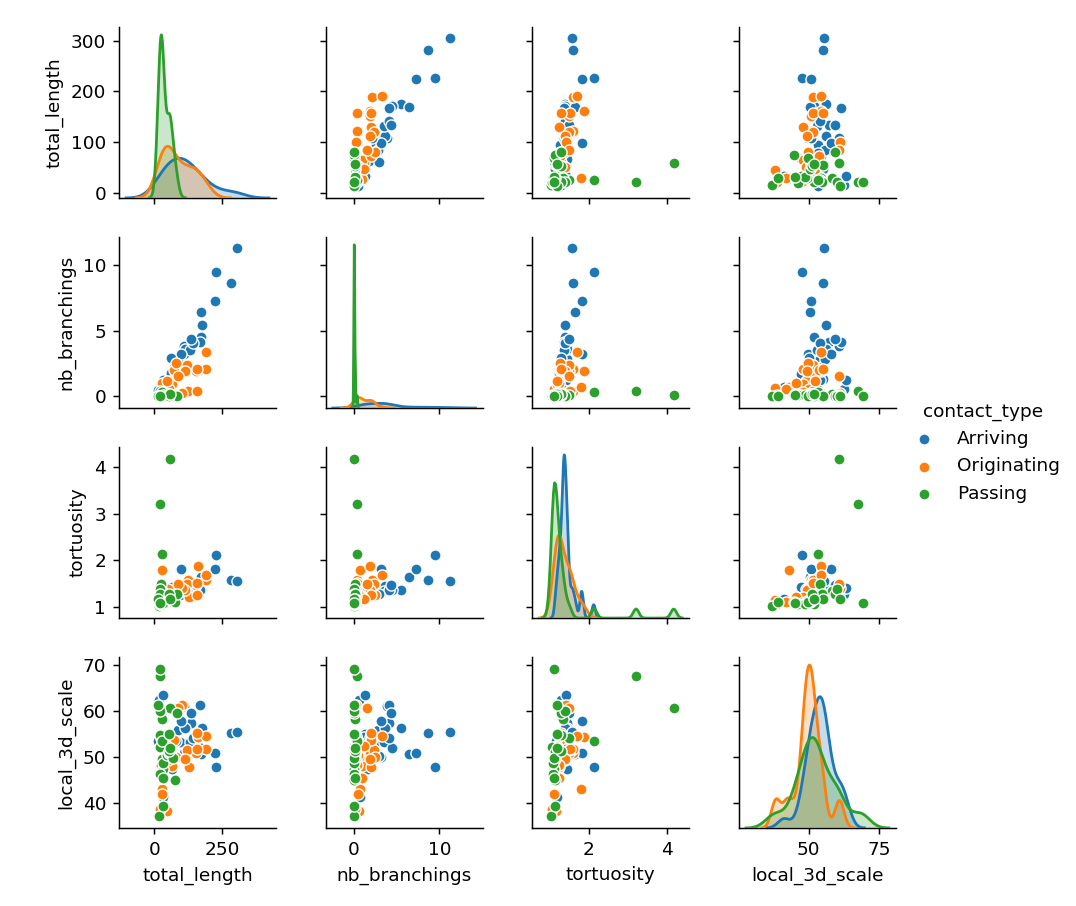

In [5]:
sns.pairplot(sdf_group,hue="contact_type", vars=["total_length","nb_branchings","tortuosity","local_3d_scale"], height=1.7);

# Heat map

Display the mean values of a feature (branchings, lengths, tortuosities, local 3d scales) across brain regions.

In [9]:
# set a color map
mycmp = cm.get_cmap('rainbow')

In [10]:
# can set feature as "total_length, nb_branchings, tortuosity, local_3d_scale"
feature = "total_length"

In [11]:
# feature values are clipped between [0th, 95th] percentile for clear visual
feature_minval = sdf_group[feature].min()
feature_maxval = np.percentile(sdf_group[feature],95)
print("min, max feature values for cliping:",feature_minval,feature_maxval)

# create new column for clipped values
sdf_group[feature+"_clipped"] = np.clip(sdf_group[feature].values,feature_minval,feature_maxval)

min, max feature values for cliping: 13.369484462472846 189.93560814158587


<IPython.core.display.Javascript object>


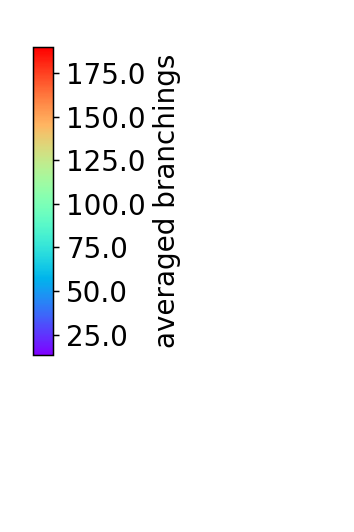

In [12]:
# plot colorbar
fig, ax = plt.subplots(figsize=(2, 3))
fig.subplots_adjust(right=0.2)

norm = mpl.colors.Normalize(vmin=feature_minval, vmax=feature_maxval)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=mycmp,
                                norm=norm,
                                orientation='vertical')

ax.set_yticklabels(cb1.get_ticks(),fontsize=15,color="k");
cb1.set_label("averaged branchings",fontsize=15,color="k");

# fig.savefig("output/avg_"+str(feature)+"_cbar.png",dpi=300)

<IPython.core.display.Javascript object>


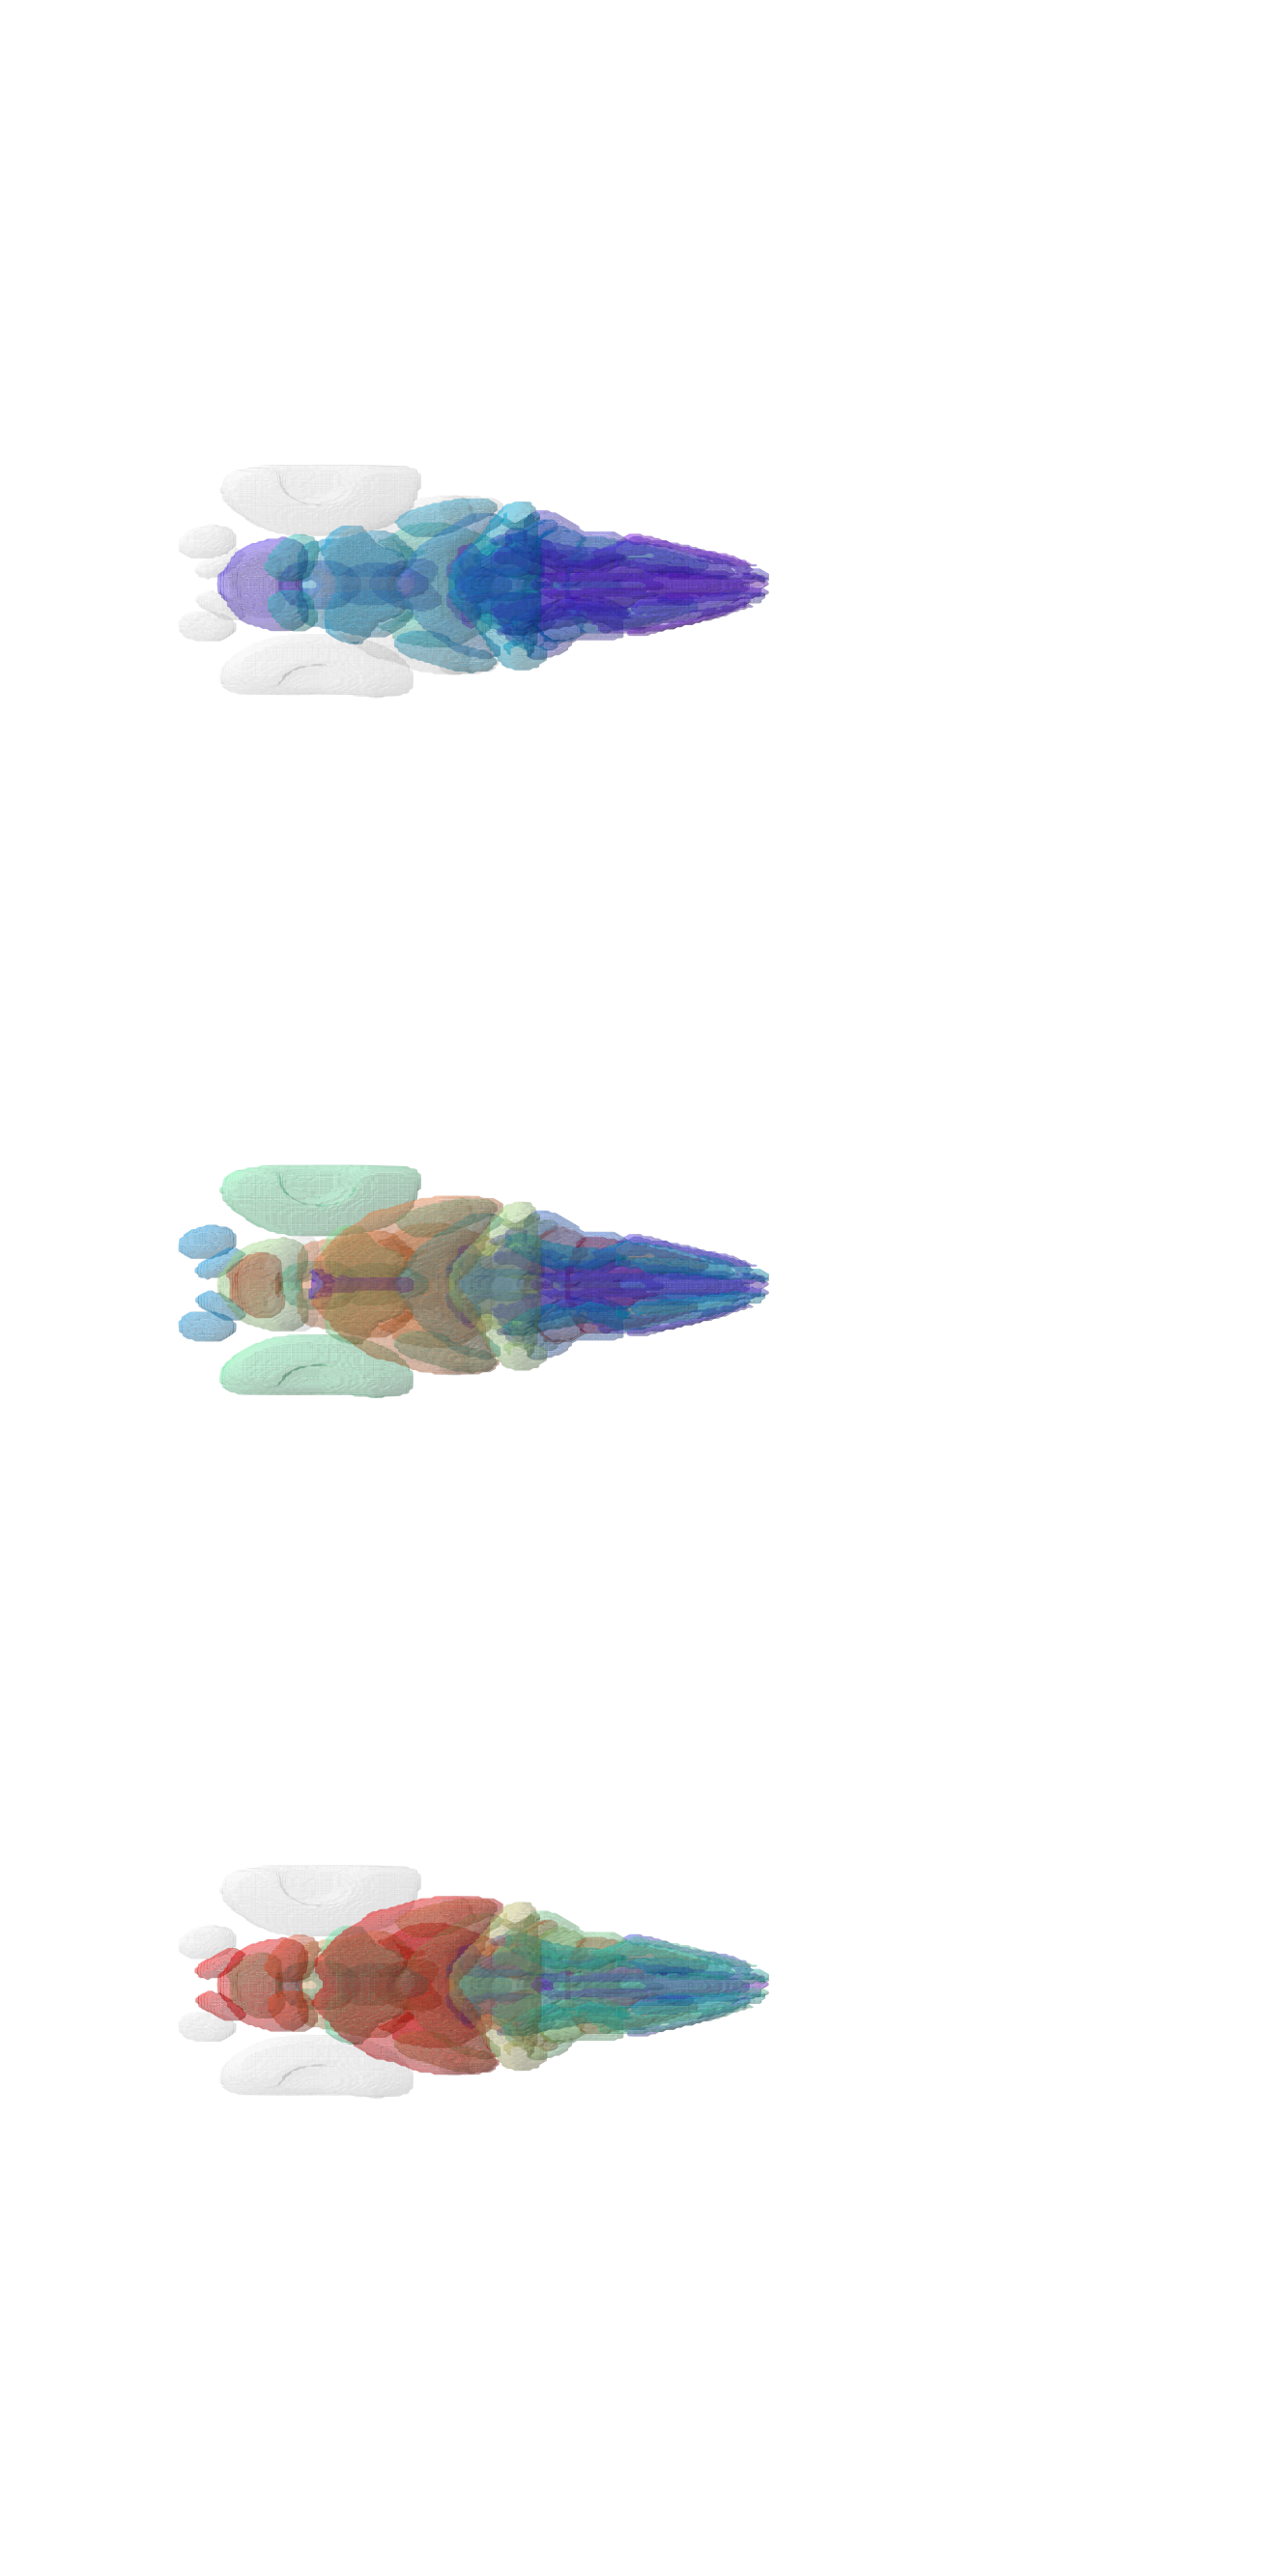

In [13]:
# plot heatmap for different contact types
# plot order: passing, originating, arriving

fig = plt.figure(figsize=(10,20))

azim = 0
elev = 90 # set 0 for AP-DV, and 90 for AP-ML
dist = 50

ax = fig.add_subplot(311,projection='3d')
ssdf = sdf_group[sdf_group["contact_type"]=="Passing"]
for key,surf in brain_surfs.items(): # excluded weak strength regions
    try:
        clc = mycmp((ssdf.loc[key][feature+"_clipped"] - feature_minval)/(feature_maxval-feature_minval))    
        surf.plot(ax,args_3d={'color':clc,'alpha':0.25});
    except:
        surf.plot(ax,args_3d={'color':"white",'alpha':0.1});
# ax.set_facecolor((0., 0., 0.));
ax.view_init(azim=azim,elev=elev);
ax.dist = dist
ax.axis('off');

ax = fig.add_subplot(312,projection='3d')
ssdf = sdf_group[sdf_group["contact_type"]=="Originating"]
for key,surf in brain_surfs.items(): # excluded weak strength regions
    try:
        clc = mycmp((ssdf.loc[key][feature+"_clipped"] - feature_minval)/(feature_maxval-feature_minval))    
        surf.plot(ax,args_3d={'color':clc,'alpha':0.25});
    except:
        surf.plot(ax,args_3d={'color':"white",'alpha':0.1});  
# ax.set_facecolor((0., 0., 0.));
ax.view_init(azim=azim,elev=elev);
ax.dist = dist
ax.axis('off');

ax = fig.add_subplot(313,projection='3d')
ssdf = sdf_group[sdf_group["contact_type"]=="Arriving"]
for key,surf in brain_surfs.items(): # excluded weak strength regions
    try:
        clc = mycmp((ssdf.loc[key][feature+"_clipped"] - feature_minval)/(feature_maxval-feature_minval))    
        surf.plot(ax,args_3d={'color':clc,'alpha':0.25});
    except:
        surf.plot(ax,args_3d={'color':"white",'alpha':0.1});
# ax.set_facecolor((0., 0., 0.));
ax.view_init(azim=azim,elev=elev);
ax.dist = dist
ax.axis('off');

# fig.savefig("output/avg_"+str(feature)+"_heatmap.png",dpi=300)

# Neurons arriving to Tectum 

This section is used to illustrate neurons arriving to the Tectum as shown in the figure 2 of the paper.

In [18]:
# create swc importer
filepath = "input/swc/"
f = swc.SWC(filepath,recursive=True)
print(f.get_neuron_id())

T_170714_5_1                                      0
T_160524_4_2                                      1
T_170601_13_2                                     2
T_161108_14_2                                     3
T_160607_16_1                                     4
                                               ... 
20161005_1013_BGUG_HuC_ltRFP_d6_F11_Neuron2    1934
T_160527_1_1                                   1935
T_170529_15_2                                  1936
T_160527_19_1                                  1937
T_161010_16_2                                  1938
Length: 1939, dtype: int64


In [19]:
# get information for Tectum
regid = 30 # Tectum ID
sdf_group.loc[regid]

contact_type  sub_region_id    neuron_id  total_length  \
region_id                                                          
30            Arriving            1.0  1016.839161    304.234723   
30         Originating            1.0  1042.491525    157.989858   

           nb_branchings  tortuosity  count  local_3d_scale  \
region_id                                                     
30             11.265734    1.547714    143       55.424438   
30              0.423729    1.516077     59       51.594353   

           total_length_clipped  
region_id                        
30                   189.935608  
30                   157.989858

In [20]:
# get IDs of neurons arriving to the Tectum
neuidlst = sdf[(sdf["region_id"]==regid)&(sdf["contact_type"]=="Arriving")]["neuron_id"].unique()
print("list of neuron IDs:",neuidlst)

list of neuron IDs: [   8   25   29   83   88  154  158  163  166  174  183  196  200  201
  214  251  274  303  330  334  383  389  391  408  443  445  458  466
  474  482  487  492  496  499  559  563  579  590  602  604  609  632
  640  665  668  674  691  708  732  788  812  818  830  835  858  861
  868  869  876  883  893  903  930  931  955  971  972 1041 1046 1059
 1063 1074 1086 1111 1118 1124 1128 1135 1144 1146 1167 1173 1183 1189
 1200 1205 1209 1219 1235 1238 1244 1247 1259 1263 1272 1287 1298 1299
 1320 1329 1330 1342 1407 1415 1416 1433 1463 1518 1519 1532 1539 1556
 1557 1579 1584 1600 1601 1605 1611 1614 1616 1651 1666 1672 1701 1717
 1726 1733 1738 1754 1755 1758 1806 1807 1825 1830 1839 1844 1849 1865
 1885 1911 1912]


In [21]:
# get neurons from neuron IDs
neurons = f.get_neurons(neuidlst)

In [22]:
# get outline surface of the Tectum
surf = brain_surfs[regid]

<IPython.core.display.Javascript object>


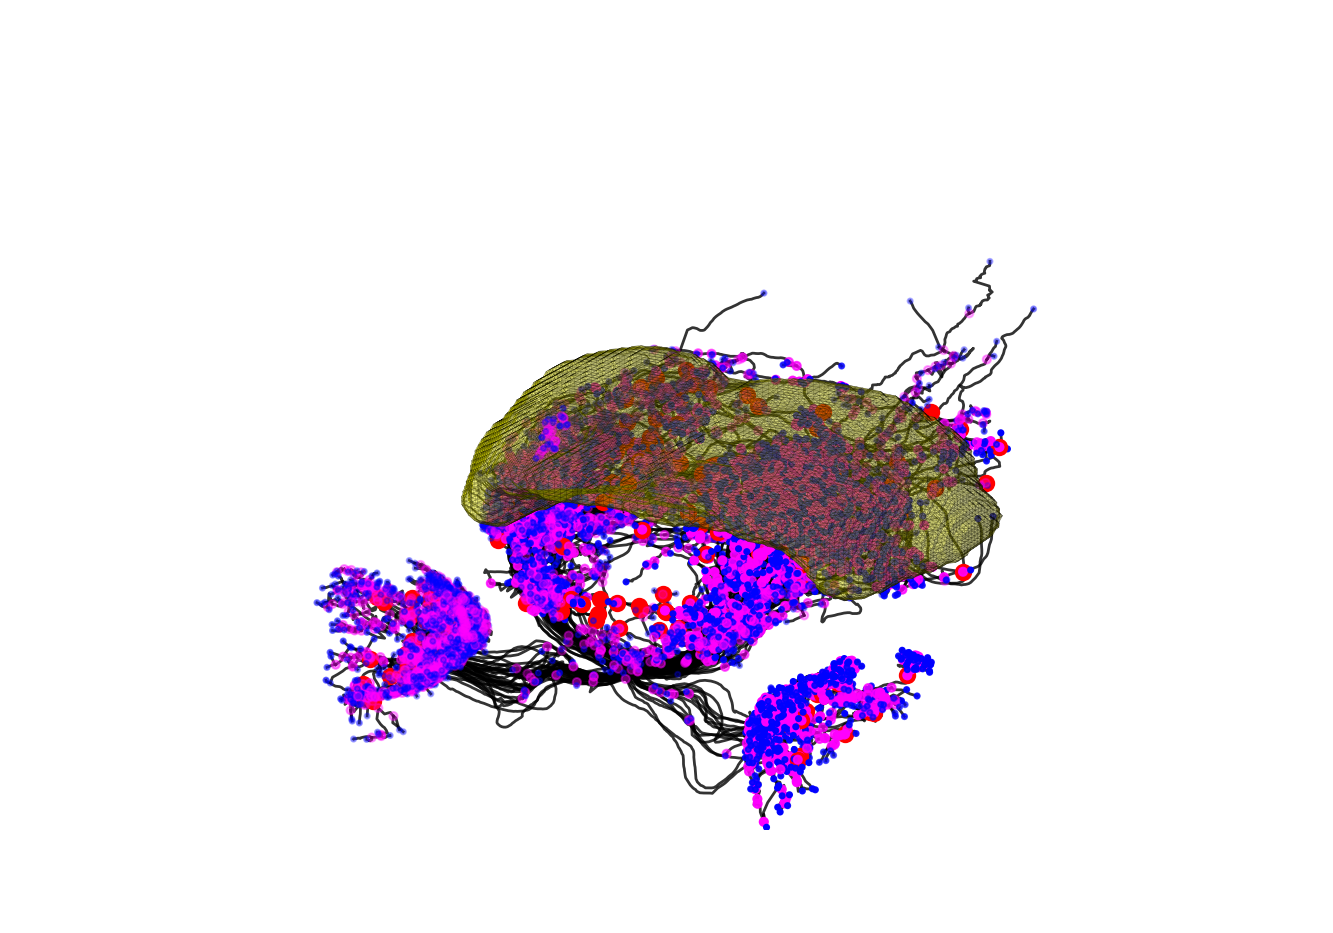

In [23]:
# 3D plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111,projection='3d')
for neu in neurons.values():
    neu.plot(ax,root_args={"s":70});
surf.plot(ax,args_3d={'color':"yellow",'alpha':0.3,'edgecolor':'black',"linewidth":0.2});
ax.axis("off");